# CE-40959: Deep Learning
## HW5 - Generative Adversarial Networks
#### 32 Points | Deadline: 4th of Khordad

---

Name: Sadroddin Barikbin

Student No.: 98208824

---

**!!! CAUTION !!!**

* Please **remove the in training generated images** when you want to upload your assignment; but **keep the "Final Visualization"** section outputs.

* To prevent Colab from disconnecting, insert the following javascript code into the inspector's console.


More info: 
[medium](https://medium.com/@shivamrawat_756/how-to-prevent-google-colab-from-disconnecting-717b88a128c0),
[stackoverflow](https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting)
```
function ClickConnect(){
  console.log("Working"); 
  document
    .querySelector("#top-toolbar > colab-connect-button")
    .shadowRoot
    .querySelector("#connect")
    .click()
}
setInterval(ClickConnect,60000)
```
---


In [0]:
#################### Problem 00 ####################
# Remember to write your Name and Student No. in the first cell :D
####################### End ########################

In [1]:
!pip install gpustat

     |████████████████████████████████| 81kB 3.6MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-cp36-none-any.whl size=12622 sha256=3403f86b36e5ed26906664cad478f6bc55111d8b733880e86dcce0e1986951f4
  Stored in directory: /root/.cache/pip/wheels/48/b4/d5/fb5b7f1d040f2ff20687e3bad6867d63155dbde5a7c10f4293
Successfully built gpustat


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm.auto import tqdm

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
CUDA = True

device = torch.device("cuda:0" if CUDA else "cpu")

In [0]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 1) Auxiliary Modules

In [0]:
class Reshape(nn.Module):
  """
  This module reshapes its input to `new_shape`
  """
  def __init__(self, new_shape):
    super().__init__()
    self.new_shape = new_shape

  def forward(self, x):
    return x.view(-1, *self.new_shape)

class NoiseGenerator(nn.Module):
  """
  This module generates `n` noises with `z_dim` dim from Normal distribution.
  """
  def __init__(self, z_dim):
    super().__init__()
    self.z_dim = z_dim

  def forward(self, n):
    noise = torch.randn(n, *self.z_dim).to(device)
    return noise

# 2) GAN Training Structure (14 points)

Complete the following class to define the GAN training structure.

In [0]:
class GANTrainer:
  """
  This class wraps the GAN training structure.

  Some arguments: \n
  `visualization_helper_fn`: Used to visualize model outputs at the end of each epoch. \n
  `G_loss_mode`: `{"logD" | "log(1-D)"}` Controls the loss function of the `generator`. \n
  `generator`: The generator. \n
  `discriminator`: The discriminator. The last layer is a LINEAR layer. \n
  """
  def __init__(self, train_dataloader:torch.utils.data.DataLoader, test_dataloader:torch.utils.data.DataLoader,
               noise_generator:NoiseGenerator, generator:nn.Module, discriminator:nn.Module,
               G_lr, D_lr,
               visualization_helper_fn, G_loss_mode):
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader

    self.noise_generator = noise_generator.to(device)
    self.generator = generator.to(device)
    self.discriminator = discriminator.to(device)

    self.visualization_helper_fn = visualization_helper_fn
    self.G_loss_mode = G_loss_mode
    
    #################### Problem 01 (1 points) ####################
    # Define Adam optimizers with `G_lr` and `D_lr` learning rates.
    ####################################################
    self.opt_G = optim.Adam(generator.parameters(),lr=G_lr)
    self.opt_D = optim.Adam(discriminator.parameters(),lr=D_lr)
    ####################### End ########################

  def generate_samples(self, n):
    """
    This function generates `n` samples.
    """
    #################### Problem 02 (1 points) ####################
    # 1) Generate `n` noises
    # 1) Transform noises to samples
    ####################################################
    noise = self.noise_generator(n)
    fake_samples = self.generator(noise)
    ####################### End ########################
    return noise, fake_samples

  def G_step(self, n):
    """
    This function calculates `generator`'s loss for `n` samples.
    """
    #################### Problem 03 (1 points) ####################
    # 1) Generate `n` fake samples. put them in `x_fake`
    # 2) Compute discriminator `logits` for generated samples
    ####################################################
    x_fake = self.generate_samples(n)[1]
    logits = self.discriminator(x_fake)
    ####################### End ########################

    if self.G_loss_mode == 'logD':
      #################### Problem 04 (2 points) ####################
      # Compute the `generator`'s loss when using `logD` as an objective.
      # `loss = mean(...)`
      #
      # CAUTION!!!!! --->>>> PAY ATTENTION TO THE SIGN OF LOSS
      ####################################################
      loss = F.binary_cross_entropy_with_logits(logits,torch.ones(logits.size(0),1,device=device))
      ####################### End ########################

    elif self.G_loss_mode == 'log(1-D)':
      #################### Problem 05 (2 points) ####################
      # Compute the `generator`'s loss when using `log(1-D)` as an objective.
      # `loss = mean(...)`
      #
      # CAUTION!!!!! --->>>> PAY ATTENTION TO THE SIGN OF LOSS
      ####################################################
      loss = -F.binary_cross_entropy_with_logits(logits,torch.zeros(logits.size(0),1,device=device))
      ####################### End ########################

    else:
      raise BaseException('Invalid generator train mode!!')
      
    return loss, x_fake

  def D_step(self, x_real):
    """
    This function calculates `discriminator`'s loss for `x_real` and `x_fake`.
    """
    #################### Problem 06 (1 points) ####################
    # 1) Generate `n` fake samples. What is the value of `n`? why?
    #  put them in `x_fake`
    # 2) Detach the generated samples. why? I do not want gradient to go back, up to the generator in this func.
    #  May be if I do not detach , it computes the gradients there but due to `generator.eval()` that I've called it does not apply them.
    ####################################################
    x_fake = self.generate_samples(1)[1]
    x_fake=x_fake.detach()
    ####################### End ########################

    #################### Problem 07 (2 points) ####################
    # Compute discriminator `loss` for `x_real` and `x_fake`. 
    # `loss = mean(...)`
    ####################################################
    flogits=self.discriminator(x_fake)
    tlogits=self.discriminator(x_real)
    loss = (F.binary_cross_entropy_with_logits(tlogits,torch.ones(x_real.size(0),1,device=device),reduction='sum')+F.binary_cross_entropy_with_logits(flogits,torch.zeros(x_fake.size(0),1,device=device),reduction='sum'))/float(x_real.size(0)+x_fake.size(0))
    ####################### End ########################

    return loss

  def train_loop(self, epoch, G_update_times, D_update_times, verbose=True):
    """
    This function iterates over `train_dataloader` and trains 
    `generator` and `discriminator` for ONE epoch.

    Some arguments: \n
    `G_update_times`: how many times to update `generator` on each batch \n
    `D_update_times`: how many times to update `discriminator` on each batch \n
    """
    train_G_loss = 0
    train_D_loss = 0

    for batch_idx, (x, _) in enumerate(tqdm(self.train_dataloader)):
      x = x.to(device)
      for _ in range(D_update_times):
        #################### Problem 08 (1 points) ####################
        # 1) Put `generator` in `eval` mode
        # 2) Put `discriminator` in `train` mode
        # 3) Zero out `opt_D`'s gradients
        # 4) Compute `discriminator`'s loss (`D_loss`); use `D_step`
        # 5) Backpropagate `D_loss`
        # 6) Update ``discriminator` parameters
        ####################################################
        self.generator.eval()
        self.discriminator.train()
        self.opt_D.zero_grad()
        D_loss = self.D_step(x)
        D_loss.backward()
        self.opt_D.step()
        ####################### End ########################

      for _ in range(G_update_times):
        #################### Problem 09 (1 points) ####################
        # 1) Put `generator` in `train` mode
        # 2) Put `discriminator` in `eval` mode
        # 3) Zero out `opt_G`'s gradients
        # 4) Compute `generator`'s loss (`G_loss`); use `G_step`
        # 5) Backpropagate `G_loss`
        # 6) Update `generator` parameters
        ####################################################
        self.generator.train()
        self.discriminator.eval()
        self.opt_G.zero_grad()
        G_loss = self.G_step(x.size(0))[0]
        G_loss.backward()
        self.opt_G.step()
        ####################### End ########################
      
      train_D_loss += D_loss.item() * x.shape[0]
      train_G_loss += G_loss.item() * x.shape[0]

      if verbose and batch_idx % LOG_INTERVAL == 0:
          print('Train | Epoch: {} [{}/{}]\t\tD-Loss: {:.6f}\tG-Loss: {:.6f}'
          .format(epoch, batch_idx * len(x), len(self.train_dataloader) * BATCH_SIZE, D_loss, G_loss))

    train_D_loss /= len(self.train_dataloader) * BATCH_SIZE
    train_G_loss /= len(self.train_dataloader) * BATCH_SIZE
    if verbose:
        print('====> Train | Epoch: {} \t | \tAverage D-loss: {:.4f} \t | \tAverage G-loss: {:.4f}'.format(epoch, train_D_loss, train_G_loss,))
    return train_G_loss, train_D_loss
  
  def test(self, verbose=True):
    """
    This function iterates over `test_dataloader` and
    reports `generator` and `discriminator` losses.
    """
    self.discriminator.eval()
    self.generator.eval()

    test_G_loss = 0
    test_D_loss = 0

    with torch.no_grad():
      for x, _ in self.test_dataloader:
        x = x.to(device)

        #################### Problem 10 (1 points) ####################
        # 1) Put `generator` in `eval` mode
        # 2) Put `discriminator` in `train` mode
        # 4) Compute `discriminator`'s loss; use `D_step`
        ####################################################
        self.generator.eval()
        self.discriminator.train()
        D_loss = self.D_step(x)
        ####################### End ########################

        #################### Problem 11 (1 points) ####################
        # 1) Put `generator` in `train` mode
        # 2) Put `discriminator` in `eval` mode
        # 4) Compute `generator`'s loss; use `G_step(n)` where `n = x.shape[0]`
        ####################################################
        self.generator.train()
        self.discriminator.eval()
        G_loss = self.G_step(x.size(0))[0]
        ####################### End ########################

        test_D_loss += D_loss.item() * x.shape[0]
        test_G_loss += G_loss.item() * x.shape[0]

            
    test_D_loss /= len(self.test_dataloader) * BATCH_SIZE
    test_G_loss /= len(self.test_dataloader) * BATCH_SIZE
    if verbose:
      print('====> Test | Average D-loss: {:.4f} \t | \tAverage G-loss: {:.4f}'.format(test_D_loss, test_G_loss,))
    return test_G_loss, test_D_loss

  def run(self, n_epoch, G_update_times=1, D_update_times=1, verbose=True):
    """
    This function will optimize parameters of `generator` and `discriminator`
    for `n_epoch` epochs on `train_dataloader` dataset and validate it on
    `test_dataloader`. At the end of each epoch, `visualization_helper_fn`
    will be called to visualize the GAN behavior.


    Some arguments: \n
    `G_update_times`: how many times to update `generator` on each batch \n
    `D_update_times`: how many times to update `discriminator` on each batch \n
    """
    trainLossG=[]
    trainLossD=[]
    testLossG=[]
    testLossD=[]
    !gpustat
    for epoch in range(1, n_epoch + 1):
        gLoss,dLoss=self.train_loop(epoch, G_update_times, D_update_times, verbose)
        trainLossG+=[gLoss]
        trainLossD+=[dLoss]
        gLoss,dLoss=self.test(verbose)
        testLossG+=[gLoss]
        testLossD+=[dLoss]
        self.visualization_helper_fn(self)
        if epoch == 1:
          !gpustat
    return (trainLossG,trainLossD),(testLossG,testLossD)

---

# 3) Part 1 - 2D Toy Dataset

In the first part, we will learn density of toy datasets to examine GAN training.

## 3.1) Helper functions
These are functions used in visulization.

In [0]:
def toy2d_density_plot(samples, title, ax=None):
  """
  This function plots the distribution of `samples`.
  """
  fig = None
  if ax is None:
    fig, ax = plt.subplots(1, figsize=(3, 3))

  samples = samples.detach().cpu().numpy()
  sns.kdeplot(samples[:, 0], samples[:, 1], shade=True, ax=ax)
  ax.set_title(title)

  if fig is not None:
    plt.show()

In [0]:
def toy2d_decision_boundary_plot(samples, labels, title, ax=None):
  """
  This function plots regions corresponding to each label value. Can be used to
  understand the decision boundary of `discriminator`.
  """
  fig = None
  if ax is None:
    fig, ax = plt.subplots(1, figsize=(3, 3))

  samples = samples.detach().cpu().numpy()
  labels = labels.detach().cpu().numpy()

  sns.scatterplot(
      x=samples[:, 0],
      y=samples[:, 1],
      hue=labels,
      legend='brief',
      marker='.',
      ax=ax
      )
  ax.set_title(title)

  if fig is not None:
    plt.show()

In [0]:
def toy2d_visulization_helper_fn(trainer: GANTrainer):
  """
  Used to visualize generator's distribution and 
  discriminator's decision boundary.
  """
  rows = 1
  cols = 2
  fig, axs = plt.subplots(rows, cols, squeeze=False, figsize=(3 * cols, 3 * rows))

  _, fake_samples = trainer.generate_samples(10000)
  random_samples = (torch.rand((10000, 2)) - .5) * 3 * R
  random_samples = random_samples.to(device)
  with torch.no_grad():
    disc_labels = torch.sigmoid(trainer.discriminator(random_samples))[:, 0]
  
  toy2d_density_plot(fake_samples, 'generator distribution', axs[0][0])
  toy2d_decision_boundary_plot(random_samples, disc_labels, 'discriminator decision boundary', axs[0][1])

  plt.show()

## 3.2) Defining Toy Datasets

In [0]:
class Toy2dCircularGaussiansDataset(torch.utils.data.Dataset):
  """
  This dataset puts 'n_modes` gaussians on a circle with 'r' radius.
  """
  def __init__(self, r=10, std_dev=1, n_modes=20, n_samples=10000):
    self.r = r
    self.std_dev = std_dev
    self.n_modes = n_modes
    
    self.mode_ids = torch.randint(high=self.n_modes, size=(n_samples,))
    theta = 2 * np.pi / n_modes * self.mode_ids
    mu = self.r * torch.stack([torch.cos(theta), torch.sin(theta)], dim=1)
    self.samples = torch.randn((n_samples, 2)) * self.std_dev + mu
  
  def __getitem__(self, i):  
    return self.samples[i], self.mode_ids[i]

  def __len__(self):
    return self.samples.shape[0]

In [0]:
class Toy2dGridGaussiansDataset(torch.utils.data.Dataset):
  """
  This dataset puts 'n_modes^2` gaussians on a grid with '2r' width and height.
  """
  def __init__(self, r=1, std_dev=1, n_modes=5, n_samples=10000):
    self.r = r
    self.std_dev = std_dev
    self.n_modes = n_modes
    assert n_modes >= 2
    
    self.mode_ids = torch.randint(high=self.n_modes, size=(n_samples, 2))
    mu = self.mode_ids * (2 * self.r / (self.n_modes - 1)) - self.r
    self.samples = torch.randn((n_samples, 2)) * self.std_dev + mu
  
  def __getitem__(self, i):  
    return self.samples[i], self.mode_ids[i]

  def __len__(self):
    return self.samples.shape[0]

## 3.3) Dataset Loading


You can load either `Toy2dCircularGaussiansDataset` or `Toy2dGridGaussiansDataset` to play with it; but the question at the end of this part is for the `Toy2dGridGaussiansDataset` dataset.

In [0]:
# parameters of toy dataset
TRAIN_SIZE = 60000
TEST_SIZE = 10000
R = 1

# ############### To use `Toy2dCircularGaussiansDataset` ############### #
# N_MODES = 8
# STD_DEV = 25e-3
# toy2d_train_dataset = Toy2dCircularGaussiansDataset(R, STD_DEV, N_MODES, TRAIN_SIZE)
# toy2d_test_dataset = Toy2dCircularGaussiansDataset(R, STD_DEV, N_MODES, TEST_SIZE)
# ###################################################################### #

# ################# To use `Toy2dGridGaussiansDataset` ################# #
N_MODES = 4
STD_DEV = 1e-4
toy2d_train_dataset = Toy2dGridGaussiansDataset(R, STD_DEV, N_MODES, TRAIN_SIZE)
toy2d_test_dataset = Toy2dGridGaussiansDataset(R, STD_DEV, N_MODES, TEST_SIZE)
# ###################################################################### #

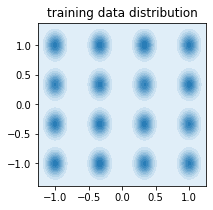

In [0]:
# Ploting dataset distribution to see it :)

toy2d_density_plot(toy2d_train_dataset[:10000][0], 'training data distribution')

## 3.4) Defining Models (4 points)

In [0]:
# Generator part
#################### Problem 12 (2 points) ####################
# 1) Define `toy2d_noise_generator`.
# 2) Define `toy2d_generator` network.
#    Use `Tanh` for intermediate layers.
#    Use `Linear` for the last layer.
####################################################
toy2d_noise_generator = NoiseGenerator((N_MODES,))

toy2d_generator = nn.Sequential(
    nn.Linear(4,2)
)
####################### End ########################

# Discriminator part
#################### Problem 13 (2 points) ####################
# 1) Define `toy2d_discriminator` network.
#    Use `Tanh` for intermediate layers.
#    Use `Linear` for the last layer. why? To transform each sample into 2-D number showing probs of being real and fake.
####################################################
toy2d_discriminator = nn.Sequential(
    nn.Linear(2,1)
)
####################### End ########################

toy2d_generator = toy2d_generator.to(device)
toy2d_discriminator = toy2d_discriminator.to(device)

print(toy2d_generator)
print(toy2d_discriminator)

Sequential(
  (0): Linear(in_features=4, out_features=2, bias=True)
)
Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)


## 3.5) Train

### 3.5.1) Batching Data

In [0]:
BATCH_SIZE = 1024

toy2d_dataloader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 4,
}

toy2d_train_dataloader = torch.utils.data.DataLoader(toy2d_train_dataset, **toy2d_dataloader_kwargs)
toy2d_test_dataloader = torch.utils.data.DataLoader(toy2d_test_dataset, **toy2d_dataloader_kwargs)

### 3.5.2) Run (2 points)

In [0]:
LOG_INTERVAL = 50
#################### Problem 14 (1 points) ####################
# Tune `generator` and `discriminator` learning rates
# and also the `G_LOSS_MODE`.
####################################################
TOY2D_G_LEARNING_RATE = 0.001
TOY2D_D_LEARNING_RATE = 0.001
G_LOSS_MODE = 'logD'
####################### End ########################

toy2d_trainer = GANTrainer(toy2d_train_dataloader, toy2d_test_dataloader,
                           toy2d_noise_generator, toy2d_generator, toy2d_discriminator,
                           TOY2D_G_LEARNING_RATE, TOY2D_D_LEARNING_RATE,
                           toy2d_visulization_helper_fn, G_LOSS_MODE)

In [0]:
#################### Problem 15 (1 points) ####################
# Tune `n_epoch`, `G_update_times` and `D_update_times`
####################################################
toy2d_trainer.run(n_epoch=50, G_update_times=1, D_update_times=1, verbose=True)
####################### End ########################

Output hidden; open in https://colab.research.google.com to view.

### 3.5.3) Final Visualization
It is an evaluating criteria for network architecture and parameter tuning (problems 12 to 15)

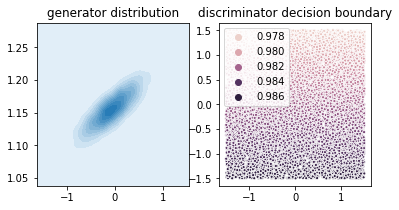

In [0]:
toy2d_visulization_helper_fn(toy2d_trainer)

## 3.6) Question (4 points)
Train GAN on `Toy2dGridGaussiansDataset` dataset for ENOUGH epochs.
We hope that our desired problem has occured for your model :)

Is the generator successful to learn the entire target distribution?
* (3 points) Define the *\"Mode Collapse\"* problem of GANs.
* (1 points) Why do you think this problem happens?

<div dir="rtl"> 
‫‫به این مشکل چسبیدگی به قله گفته میشود.
</div>

<div dir="rtl"> 
<b>
وقتی توزیع داده چند قله داشته باشد در گن گاهی اینطور پیش می آید که توزیع مولد روی یکی از قله ها قله می زند و با ادامه فرایند آموزش از آن قله به قله دیگری می رود و همه قله های توزیع داده را نمی سازد.این مشکل را چسبیدگی به قله می گویند.

وقتی مولد ببیند تمییز دهنده گول خورده است تولیدات خود را حول آن تولید موفقش متمرکز می کند.
</b>


</div>

# 4) Part 2 - MNIST

In the second part, we will learn to generate MNIST like samples.

## 4.1) Helper functions
These are functions used in visulization.

In [0]:
def vector_linspace(start, end, steps):
  """
  Vector version of torch linspace
  """
  result = []
  for dim in range(start.shape[0]):
    result.append(torch.linspace(start[dim], end[dim], steps))
  result = torch.stack(result, dim=1).to(device)
  return result

In [0]:
def mnist_show(image_batch, rows=1):
  """
  This function gets multiple MNIST images and plots them in the given number of rows.
  """
  image_batch = image_batch.detach().cpu()
  image_batch = image_batch.view(-1, 28, 28)
  image_batch = image_batch.numpy()

  cols = np.ceil(image_batch.shape[0] / rows)
  plt.rcParams['figure.figsize'] = (cols, rows) # set default size of plots  TODO float(folan)?
  
  for i in range(image_batch.shape[0]):
      plt.subplot(rows, cols, i + 1)
      plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
      plt.axis('off')
  plt.show()

In [0]:
def mnist_visulization_helper_fn(trainer: GANTrainer):
  """
  Generates fake samples and plots them for you.
  """
  _, fake_samples = trainer.generate_samples(30)
  mnist_show(fake_samples, 3)

In [0]:
def show_interpolations(trainer:GANTrainer, n_rows, n_cols):
    """
    Shows image interpolation (grid of [`n_rows`, `n_cols`]) in input noise space.
    """
    anchor_noises = trainer.noise_generator(4)
    left_column = vector_linspace(anchor_noises[0], anchor_noises[1], n_rows)
    right_column = vector_linspace(anchor_noises[2], anchor_noises[3], n_rows)
    rows = []
    for i in range(n_rows):
      rows.append(vector_linspace(left_column[i], right_column[i], n_cols))
    noises = torch.stack(rows, dim=0).view(n_rows * n_cols, -1)
    with torch.no_grad():
      fake_imgs = trainer.generator(noises)
    mnist_show(fake_imgs, n_rows)

## 4.2) Dataset Loading

In [24]:
# Get MNIST dataloader

mnist_dataset_kwargs = {
    'download': True,
    'transform': transforms.Compose([
                                     transforms.ToTensor(),
                                     lambda img: img * 2 - 1, # to make pixel values between [-1, 1]
                                    #  lambda img: torch.transpose(img, 1, 2)
                                     ])
}

mnist_train_dataset = datasets.MNIST('./data', train=True, **mnist_dataset_kwargs)
mnist_test_dataset = datasets.MNIST('./data', train=False, **mnist_dataset_kwargs)

print(len(mnist_train_dataset))

60000


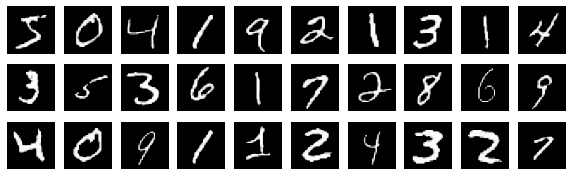

In [0]:
temp = torch.stack([mnist_train_dataset[i][0] for i in range(30)], dim=0)
mnist_show(temp, 3)

## 4.3) Defining Models (6 points)

In [42]:
# Generator part
#################### Problem 16 (3 points) ####################
# 1) Define `mnist_noise_generator`.
# 2) Define `mnist_generator` network.
#    Use `LeakyReLU` for intermediate layers.
#    Use `Tanh` for the last layer.
#    Use convolution layers.
#    Can use batch norm, dropout, ...
####################################################
mnist_noise_generator = NoiseGenerator((10,))

mnist_generator = nn.Sequential(
    nn.Linear(10,324),
    nn.LeakyReLU(),
    nn.Dropout(),
    Reshape((1,18,18)),
    nn.ConvTranspose2d(1,5,2),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(5,5,3),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(5,3,4),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(3,1,5),
    nn.Tanh()
)
####################### End ########################

# Discriminator part
#################### Problem 17 (3 points) ####################
# 1) Define `toy2d_discriminator` network.
#    Use `LeakyReLU` for intermediate layers.
#    Use `Linear` for the last layer. why?
#    Use convolution layers.
#    Can use batch norm, dropout, ...
####################################################
mnist_discriminator = nn.Sequential(
    # nn.Conv2d(1,5,3),
    # nn.MaxPool2d(5,padding=2),
    # nn.Conv2d(5,8,3),
    # nn.MaxPool2d(2),
    # nn.LeakyReLU(),
    # nn.Flatten(),
    # nn.Linear(32,10),
    # nn.LeakyReLU(),
    # nn.Linear(10,1)
    nn.Conv2d(1,5,3),
    nn.LeakyReLU(),
    nn.Conv2d(5,5,4),
    nn.LeakyReLU(),
    nn.Conv2d(5,4,5,stride=2),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(100,10),
    nn.LeakyReLU(),
    nn.Linear(10,1),
)
####################### End ########################

mnist_generator = mnist_generator.to(device)
mnist_discriminator = mnist_discriminator.to(device)

print(mnist_generator)
print(mnist_discriminator)

Sequential(
  (0): Linear(in_features=10, out_features=324, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.5, inplace=False)
  (3): Reshape()
  (4): ConvTranspose2d(1, 5, kernel_size=(2, 2), stride=(1, 1))
  (5): LeakyReLU(negative_slope=0.01)
  (6): ConvTranspose2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (7): LeakyReLU(negative_slope=0.01)
  (8): ConvTranspose2d(5, 3, kernel_size=(4, 4), stride=(1, 1))
  (9): LeakyReLU(negative_slope=0.01)
  (10): ConvTranspose2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
  (11): Tanh()
)
Sequential(
  (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(5, 5, kernel_size=(4, 4), stride=(1, 1))
  (3): LeakyReLU(negative_slope=0.01)
  (4): Conv2d(5, 4, kernel_size=(5, 5), stride=(2, 2))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=100, out_features=10, bias=True)
  (8): LeakyReLU(negative_slope=0.01)


## 4.4) Train

### 4.4.1) Batching Data

you can use `train_sampler` and `test_sampler` to test your model on smaller subset of dataset; but, the final report must be on the whole dataset.

In [0]:
BATCH_SIZE = 256

mnist_dataloader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'pin_memory': True,
    'num_workers': 4,
}

# # ############### To use complete dataset ############### #
train_sampler = None
test_sampler = None
mnist_dataloader_kwargs['shuffle'] = True
# # ####################################################### #

############### To use subsample of dataset ############### #
# train_sampler = torch.utils.data.RandomSampler(mnist_train_dataset, replacement=True, num_samples=10000)
# test_sampler = torch.utils.data.RandomSampler(mnist_test_dataset, replacement=True, num_samples=2000)
# mnist_dataloader_kwargs['shuffle'] = False
########################################################### #

mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_dataset, sampler=train_sampler, **mnist_dataloader_kwargs)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_dataset, sampler=test_sampler, **mnist_dataloader_kwargs)

### 4.4.2) Run (2 points)

In [0]:
LOG_INTERVAL = 50
#################### Problem 18 (1 points) ####################
# Tune `generator` and `discriminator` learning rates
# and also the `G_LOSS_MODE`.
####################################################
MNIST_G_LEARNING_RATE = 0.001
MNIST_D_LEARNING_RATE = 0.0001
G_LOSS_MODE = 'logD'
####################### End ########################

mnist_trainer = GANTrainer(mnist_train_dataloader, mnist_test_dataloader,
                           mnist_noise_generator, mnist_generator, mnist_discriminator,
                           MNIST_G_LEARNING_RATE, MNIST_D_LEARNING_RATE,
                           mnist_visulization_helper_fn, G_LOSS_MODE)

cb3d0545e33a             Wed May 27 03:54:42 2020  418.67
[0] Tesla P100-PCIE-16GB | 38'C,   0 % |   763 / 16280 MB |


Train | Epoch: 1 [0/60160]		D-Loss: 0.004109	G-Loss: 0.029441
Train | Epoch: 1 [12800/60160]		D-Loss: 0.005404	G-Loss: 0.015884
Train | Epoch: 1 [25600/60160]		D-Loss: 0.024857	G-Loss: 0.034792
Train | Epoch: 1 [38400/60160]		D-Loss: 0.003246	G-Loss: 0.009629
Train | Epoch: 1 [51200/60160]		D-Loss: 0.000368	G-Loss: 0.017139

====> Train | Epoch: 1 	 | 	Average D-loss: 0.0037 	 | 	Average G-loss: 0.0249
====> Test | Average D-loss: 0.0025 	 | 	Average G-loss: 0.0168


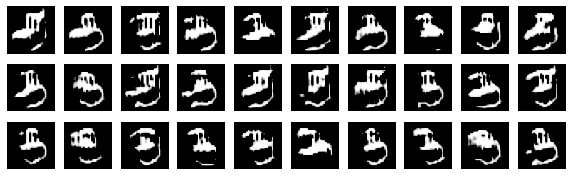

cb3d0545e33a             Wed May 27 03:54:55 2020  418.67
[0] Tesla P100-PCIE-16GB | 39'C,   0 % |   763 / 16280 MB |


Train | Epoch: 2 [0/60160]		D-Loss: 0.002465	G-Loss: 0.017246
Train | Epoch: 2 [12800/60160]		D-Loss: 0.000340	G-Loss: 0.016894
Train | Epoch: 2 [25600/60160]		D-Loss: 0.000403	G-Loss: 0.006355
Train | Epoch: 2 [38400/60160]		D-Loss: 0.000693	G-Loss: 0.006936
Train | Epoch: 2 [51200/60160]		D-Loss: 0.000803	G-Loss: 0.014276

====> Train | Epoch: 2 	 | 	Average D-loss: 0.0032 	 | 	Average G-loss: 0.0163
====> Test | Average D-loss: 0.0048 	 | 	Average G-loss: 0.0097


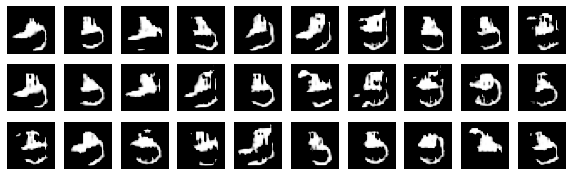

Train | Epoch: 3 [0/60160]		D-Loss: 0.000431	G-Loss: 0.006847
Train | Epoch: 3 [12800/60160]		D-Loss: 0.002605	G-Loss: 0.017298
Train | Epoch: 3 [25600/60160]		D-Loss: 0.000541	G-Loss: 0.012055
Train | Epoch: 3 [38400/60160]		D-Loss: 0.001987	G-Loss: 0.016302
Train | Epoch: 3 [51200/60160]		D-Loss: 0.001604	G-Loss: 0.023729

====> Train | Epoch: 3 	 | 	Average D-loss: 0.0038 	 | 	Average G-loss: 0.0110
====> Test | Average D-loss: 0.0022 	 | 	Average G-loss: 0.0150


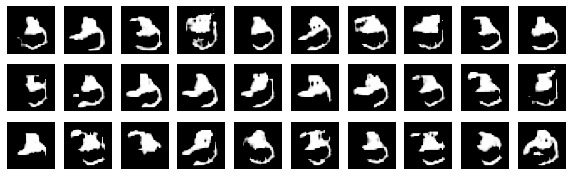

Train | Epoch: 4 [0/60160]		D-Loss: 0.002528	G-Loss: 0.018134
Train | Epoch: 4 [12800/60160]		D-Loss: 0.004678	G-Loss: 0.006238
Train | Epoch: 4 [25600/60160]		D-Loss: 0.000349	G-Loss: 0.019404


In [0]:
#################### Problem 19 (1 points) ####################
# Tune `n_epoch`, `G_update_times` and `D_update_times`
####################################################50+50+10+20+30
trLosses,tsLosses=mnist_trainer.run(n_epoch=30, G_update_times=1, D_update_times=1, verbose=True)
plt.plot(trLosses[0])
plt.plot(trLosses[1])
plt.plot(tsLosses[0])
plt.plot(tsLosses[1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train G','Train D','Test G','Test D'],loc='upper right')
plt.show()
####################### End ########################

### 4.4.3) Final Visualization
It is an evaluating criteria for network architecture and parameter tuning (problems 16 to 19)

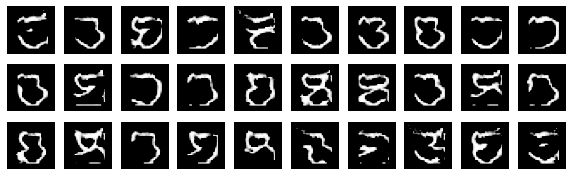

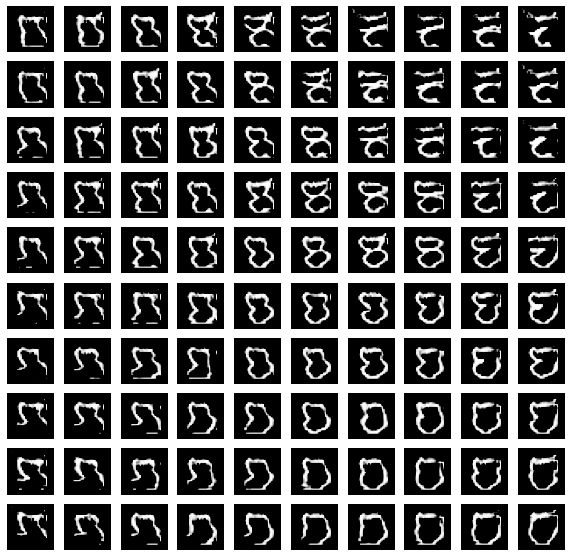

In [50]:
mnist_visulization_helper_fn(mnist_trainer)
show_interpolations(mnist_trainer, 10, 10)